# Double DQN (DDQN) Taxi with gym and TensorFlow

This is a code implementing DDQN to Taxi with the following specs,
- Epsilon decay
- No hidden layer
- One hot encoding state representation
- Skip training
- Soft target network update

In [1]:
## setup

import gym
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import numpy as np
import random
import time
from google.colab import files
import pickle

In [0]:
## hyperparameter

ENV_NAME = 'Taxi-v3'

# seed for initial position in environment
SEED = 123

# the learning rate used by RMSProp in "human-level control through deep reinforcement learning"
LEARNING_RATE = 0.00025
MOMENTUM = 0.95

# taxi environment
STATE_SIZE = 1
ONEHOT_STATE_SIZE = 500
ACTION_SIZE = 6

# soft target update
# value used in "continuous control with deep reinforcement learning"
TAU = 0.001 

# BATCH_SIZE = 32
BATCH_SIZE = 16

# gamma in Bellman equation
GAMMA = 0.99

# epsilon in epsilon greedy algorithm
# we implement epsilon decay
EPSILON = 1.0

# EPSILON_DECAY = 0.99999
# EPSILON_DECAY = 0.99995
EPSILON_DECAY = 0.9972

EPSILON_MIN = 0.1
# EPSILON_MIN = 0.01

# max step in each episode
T_RANGE = 201

# training
EPISODES = 10000
# EPISODES = 5000
# EPISODES = 100
# EPISODES = 10

MONITOR_INTERVAL = 100
# MONITOR_INTERVAL = 10
# MONITOR_INTERVAL = 1

# save files
PATH_ONLINE_SAVE_WEIGHTS = 'oneline_model.h5'
PATH_TARGET_SAVE_WEIGHTS = 'target_model.h5'
SAVE_FIG_REWARD = 'ddqn_taxi_reward.png'
SAVE_FIG_LOSS = 'ddqn_taxi_loss.png'
REWARD_OBJ = 'ddqn_reward_list.sav'
LOSS_OBJ = 'ddqn_loss_list.sav'

In [3]:
## environment

env = gym.make(ENV_NAME)
# env.seed(SEED)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [0]:
## experience replay

class Replay:
    def __init__(self):
        self.buffer = []
        self.length = 0
        self.max_length = 10000

    def write(self, data):
        if self.length >= self.max_length:
            self.buffer.pop(0)
            self.length -= 1
        self.buffer.append(data)
        self.length += 1

    def read(self, batch_size):
        # at beginning buffer is almost empty, so batch is smaller than batch_size
        return random.sample(self.buffer, min(batch_size, self.length))

In [0]:
## network

# we use the same architectures for online_network and target_network
# we _build_model 2 times

class Network:
    def __init__(self, n_in, n_out):
        self.n_in = n_in
        self.n_out = n_out

    def _build_model_1(self):
        model = Sequential()
        model.add(Dense(24, input_shape = (self.n_in,), activation = 'relu'))
        model.add(Dense(48, activation = 'relu'))
        model.add(Dense(self.n_out, activation = 'linear'))
        optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)
        model.compile(loss = 'mse', optimizer = optimizer)
        
        # debug
        # print("compiled model")
        
        return model
    
    def _build_model_2(self):
        model = Sequential()
        model.add(Dense(self.n_out, input_shape = (self.n_in,), activation = 'linear', use_bias = False))
        optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)
        model.compile(loss = 'mse', optimizer = optimizer)
        return model

In [0]:
## agent

class Agent:
    def __init__(self):
        # choose what style you want for state representation
        # self.n_in = STATE_SIZE
        self.n_in = ONEHOT_STATE_SIZE
        self.n_out = ACTION_SIZE
        self.total_reward = 0
        self.gamma = GAMMA
        self.tau = TAU
        self.epsilon = EPSILON
        self.epsilon_min = EPSILON_MIN
        self.epsilon_decay = EPSILON_DECAY
        self.batch_size = BATCH_SIZE
        self.replay_buffer = Replay()
        # choose what network you want to implement
        # self.online_model = Network(self.n_in, self.n_out)._build_model_1()
        # self.target_model = Network(self.n_in, self.n_out)._build_model_1()
        self.online_model = Network(self.n_in, self.n_out)._build_model_2()
        self.target_model = Network(self.n_in, self.n_out)._build_model_2()

    def gather_experience(self, last_observation, action, reward, observation):
        self.replay_buffer.write((last_observation, action, reward, observation))

    # set total reward
    def set_total_reward(self, new_total):
        self.total_reward = new_total

        # debug
        # print("initialized total reward")

    # gather reward
    def gather_reward(self, reward):
        self.total_reward += reward

    # get total rewards
    def get_total_reward(self):
        return self.total_reward

    # we start from large epsilon and gradually decay the epsilon in each episode
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
            # debug
            # print("decayed epsilon")
            
    # reshape state for model
    # def reshape_state(self, state):
        # return np.reshape(state, newshape = (self.n_in, ))
        
    def one_hot_encode(self, observation):
        state = np.zeros(self.n_in)
        state[observation] = 1
        state = np.reshape(state, (-1, self.n_in))
        return state

    # return action index
    def choose_action(self, observation):
        # epsilon greedy policy is performed here
        # exploitation
        # np.random.rand is uniform [0,1]
        if np.random.rand() > self.epsilon:
            state = self.one_hot_encode(observation)
            return np.argmax(self.online_model.predict(state)[0])
            
        # exploration
        else:
            # random action from 0 to 5 out of 6 actions
            return int(np.random.randint(low = 0, high = self.n_out - 1, size = 1, dtype = 'int'))

    # update q values
    # train online model
    def q_update(self):
        # batch to update q values and train online model
        batch = self.replay_buffer.read(self.batch_size)
        n = np.shape(batch)[0]
        
        # initialize training data
        x_batch = np.zeros([n, self.n_in])
        y_batch = np.zeros([n, self.n_out])
        
        counter = 0
        
        for b in batch:
            
            # debug
            # print("working?")
            
            last_state, action, reward, state = b
            
            last_state = self.one_hot_encode(last_state)
            # [0] because tf nn output is list of list
            q_last = self.online_model.predict(last_state)[0]
            
            if state is None:
                # TODO 20191209 Yuki
                q_this = reward
            else:
                state = self.one_hot_encode(state)
                
                # Double DQN logic ---------------------------------------------------------
                # select action by online model
                action_online = np.argmax(self.online_model.predict(state)[0])
                # evaluate action by target model
                q_this_target = self.target_model.predict(state)[0][action_online]
                # Bellman equation
                q_this = reward + self.gamma * q_this_target
                # --------------------------------------------------------------------------
                
            # update q values
            q_last[action] = q_this
            # store y data
            # y_batch.append(q_last)
            x_batch[counter, :] = last_state
            y_batch[counter, :] = q_last
            counter += 1
        
        # train online model
        history = self.online_model.fit(x_batch, y_batch, epochs = 1, verbose = 0)
        
        # debug
        # print("tained online model")
        
        # return online model loss
        return history.history['loss'][0]
        
    # update target model
    def update_target_model(self):
        # get_weights returns list of weights of each layer
        theta_online = self.online_model.get_weights()
        theta_target = self.target_model.get_weights()
        
        # soft target update from "continuous control with DRL"
        counter = 0
        for weight_online, weight_target in zip(theta_online, theta_target):
            # This equations need to be compared with paper
            # target weight is a weighted average of target weight and online weight
            weight_target = weight_target * (1 - self.tau) + weight_online * self.tau
            # update target weight
            theta_target[counter] = weight_target
            # iterate
            counter += 1
        
        # update target model
        self.target_model.set_weights(theta_target)
        
        # debug
        # print("updated target model")

In [7]:
## training

agent = Agent()
ep_rewards = []
loss = False
losses = []
start_time = time.time()

for ep in range(EPISODES):

    # initialize
    # env.reset() in taxi returns index of states out of 500
    last_observation = env.reset()
    agent.set_total_reward(0)

    # iterations within an episode
    for t in range(T_RANGE):

        # draw action
        action = agent.choose_action(last_observation)
        # draw next state and reward
        observation, reward, done, info = env.step(action)

        # when taxi drop a passenger at destination, done = True
        if done == True:
            observation = None

        # accumulate reward
        agent.gather_reward(reward)
        agent.gather_experience(last_observation, action, reward, observation)

        # update q values
        if np.random.random() < 0.3 and len(ep_rewards) > 0:
            if ep_rewards[-1] < 9.7:
                # train online model
                loss = agent.q_update()
                
                # update target model
                agent.update_target_model()
            
        # iterate
        last_observation = observation

        # goal
        if done == True:
            ep_rewards.append(agent.get_total_reward())
            break

    # store last loss of online model
    if loss:
        losses.append(loss)

    # In each episode we decay epsilon
    agent.decay_epsilon()

    # Monitor total reward during episodes
    if ep % MONITOR_INTERVAL == 0 and loss:
        print("episode:", ep,
              "reward:", agent.get_total_reward(),
              "loss:", np.round(loss, decimals = 3), 
              "epsilon:", np.round(agent.epsilon, decimals = 5),
              "time: {} seconds".format(np.round(time.time() - start_time, decimals = 0)))
        
# when training finishes

# save weights of neural network
agent.online_model.save(PATH_ONLINE_SAVE_WEIGHTS)
agent.target_model.save(PATH_TARGET_SAVE_WEIGHTS)

# plot the reward result
#episode = range(0, EPISODES, 1)
#plt.plot(episode, ep_rewards)
#plt.ylabel("total rewards per episode")
#plt.xlabel("episode")
#plt.title("DQN Taxi rewards")
#plt.savefig(SAVE_FIG_REWARD)
#plt.show()

# plot the loss result
#episode = range(0, losses, 1)
#plt.plot(episode, losses)
#plt.ylabel("loss per episode")
#plt.xlabel("episode")
#plt.title("DQN Taxi rewards")
#plt.savefig(SAVE_FIG_LOSS)
#plt.show()

# save object
#pickle.dump(ep_rewards, open(REWARD_OBJ, 'wb'))
#pickle.dump(losses, open(LOSS_OBJ, 'wb'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
episode: 100 reward: -623 loss: 5.26 epsilon: 0.75337 time: 332.0 seconds
episode: 200 reward: -1010 loss: 4.226 epsilon: 0.56916 time: 665.0 seconds
episode: 300 reward: -1181 loss: 5.217 epsilon: 0.42999 time: 1012.0 seconds
episode: 400 reward: -1298 loss: 6.209 epsilon: 0.32486 time: 1363.0 seconds
episode: 500 reward: -695 loss: 5.185 epsilon: 0.24542 time: 1710.0 seconds
episode: 600 reward: -398 loss: 3.164 epsilon: 0.18541 time: 2064.0 seconds
episode: 700 reward: -920 loss: 2.136 epsilon: 0.14008 time: 2421.0 seconds
episode: 800 reward: -506 loss: 10.172 epsilon: 0.10583 time: 2778.0 seconds
episode: 900 reward: -740 loss: 7.128 epsilon: 0.09978 time: 3129.0 seconds
episode: 1000 reward: -1217 loss: 5.151 epsilon: 0.09978 time: 3481.0 seconds
episode: 1100 reward: -344 loss: 10.225 epsilon: 0.09978 time: 3834.0 seconds
episode: 1200 reward: -884 loss: 5.141 epsilon: 0.09978 time: 4191.0 seconds
e

NameError: ignored

In [0]:
# save object
pickle.dump(ep_rewards, open(REWARD_OBJ, 'wb'))
pickle.dump(losses, open(LOSS_OBJ, 'wb'))

In [0]:
files.download(PATH_ONLINE_SAVE_WEIGHTS)

In [0]:
files.download(PATH_TARGET_SAVE_WEIGHTS)

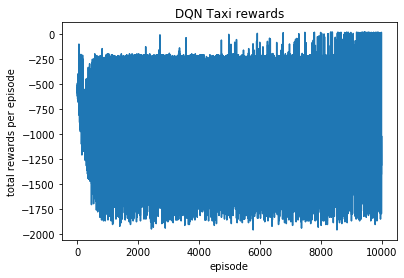

TypeError: ignored

In [10]:
import matplotlib.pyplot as plt
# plot the reward result
episode = range(0, EPISODES, 1)
plt.plot(episode, ep_rewards)
plt.ylabel("total rewards per episode")
plt.xlabel("episode")
plt.title("DQN Taxi rewards")
plt.savefig(SAVE_FIG_REWARD)
plt.show()

# plot the loss result
#episode = range(0, losses, 1)
#plt.plot(episode, losses)
#plt.ylabel("loss per episode")
#plt.xlabel("episode")
#plt.title("DQN Taxi rewards")
#plt.savefig(SAVE_FIG_LOSS)
#plt.show()

# save object
pickle.dump(ep_rewards, open(REWARD_OBJ, 'wb'))
pickle.dump(losses, open(LOSS_OBJ, 'wb'))

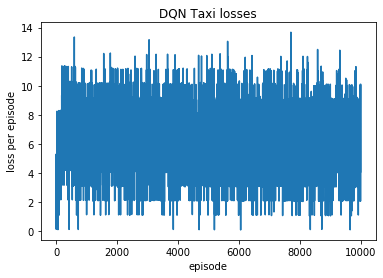

In [18]:
# plot the loss result
episode = range(0, len(losses), 1)
plt.plot(episode, losses)
plt.ylabel("loss per episode")
plt.xlabel("episode")
plt.title("DQN Taxi losses")
plt.savefig(SAVE_FIG_LOSS)
plt.show()

In [0]:
files.download(SAVE_FIG_REWARD)

In [0]:
files.download(SAVE_FIG_LOSS)

In [0]:
files.download(REWARD_OBJ)

In [0]:
files.download(LOSS_OBJ)

In [0]:
## debug q update

# experiences = []
# # (last_observation, action, reward, observation)
# experiences.append((1, 0, -1, 2))
# experiences.append((2, 1, -1, 3))
# experiences.append((3, 2, -1, 4))
# # print(experiences)

# BATCH_SIZE = 2

# net = Network(1, 6)
# online_model = net._build_model()
# target_model = net._build_model()

# # reshape state for model
# def reshape_state(state):
#     return np.reshape(state, newshape = (STATE_SIZE, -1))


# # def q_update(self):
# def q_update():
#     # sample batch
#     batch = random.sample(experiences, BATCH_SIZE)
#     print(batch)
    
#     # [0] because list of list
#     last_state_input = reshape_state([s[0] for s in batch])[0]
#     state_input = reshape_state([b[3] for b in batch if b[3] is not None])[0]
#     print(last_state_input)
#     print(state_input)
    
#     q_last = online_model.predict(last_state_input)
#     print(q_last)
    
#     q_this = np.zeros_like(q_last)
#     print(q_this)
    
#     ind_not_none = [i for i in range(np.shape(batch)[0]) if batch[i][3] is not None]
#     print(ind_not_none)
    
#     action_online_model = np.argmax(online_model.predict(state_input), axis = 1)
#     print("action_online_model", action_online_model)
#     # print(online_model.predict(state_input))
    
#     print("target_model.predict(state_input) \n", target_model.predict(state_input))
#     pred_target_model = target_model.predict(state_input)
#     # print(pred_target_model)
#     # print([outputs for outputs in pred_target_model])
    
#     q_value_target_model = []
#     for i in range(len(action_online_model)):
#         tmp = pred_target_model[i][action_online_model[i]]
#         q_value_target_model.append(tmp)
#     print(q_value_target_model)
    
# q_update()

In [0]:
# # easier version of q update

# experiences = []
# random.seed(1)
# # (last_observation, action, reward, observation)
# experiences.append((1, 0, -1, 2))
# experiences.append((2, 1, -1, 3))
# experiences.append((3, 2, -1, 4))
# # print(experiences)

# BATCH_SIZE = 2

# net = Network(1, 6)
# online_model = net._build_model()
# target_model = net._build_model()

# # reshape state for model
# def reshape_state(state):
#     # return np.reshape(state, newshape = (STATE_SIZE, -1))
#     return np.reshape(state, newshape = (STATE_SIZE, ))


# # def q_update(self):
# def q_update():
#     # sample batch
#     batch = random.sample(experiences, BATCH_SIZE)
#     # print(batch)
    
#     minibatch_new_q_values = []
    
#     for experience in batch:
#         last_state, action, reward, state = experience
        
#         last_state = reshape_state(last_state)
#         # [0] for list of list
#         experience_new_q_values = online_model.predict(last_state)[0]
#         # print(experience_new_q_values)
        
#         if state is None:
#             q_update = reward
#         else:
#             state = reshape_state(state)
#             action_online = np.argmax(online_model.predict(state))
#             # print("action_online", action_online)
#             # [0] for list of list
#             q_value_target = target_model.predict(state)[0][action_online]
#             # print(q_value_target)
#             q_update = reward + GAMMA * q_value_target
        
#         # print("before", experience_new_q_values)
#         experience_new_q_values[action] = q_update
#         # print("after", experience_new_q_values)
#         minibatch_new_q_values.append(experience_new_q_values)
#         # print(minibatch_new_q_values)
        
#     x_batch = np.array([b[0] for b in batch])
#     print(x_batch)
#     # x_batch = reshape_state(x_batch)
#     # print(x_batch)
#     y_batch = np.array(minibatch_new_q_values)
#     print(y_batch)
    
#     online_model.fit(x_batch, y_batch, epochs = 1)
    
# q_update()

In [0]:
# ## debug neural network model

# net = Network(1, 6)
# model = net._build_model()
# model.summary()

# data = 1
# tmp = np.reshape(data, newshape = (STATE_SIZE, -1))
# print(tmp.shape)
# print(model.predict(tmp))

# tmp = model.get_weights()
# # print(type(tmp))
# # print(len(tmp))
# # print(tmp[0])
# # print(len(tmp[0][0]))
# # print(tmp[1])
# print(tmp[0].shape)
# print(tmp[1].shape)
# print(tmp[2].shape)
# print(tmp[3].shape)
# print(tmp[4].shape)
# print(tmp[5].shape)
# # print(tmp)